In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Загружаем датасет

In [ ]:
from google.colab import drive
import pathlib

drive.mount('/content/drive')

dataset_dir = pathlib.Path('/content/drive/MyDrive/Practic/train').with_suffix('')

Mounted at /content/drive


Выводим количество изображений в датасете

In [ ]:
image_count = len(list(dataset_dir.glob("*/*.jpg")))
print(f"Всего изображений: {image_count}")

Всего изображений: 6581


# Создаем датасеты и кэшируем их

In [ ]:
batch_size = 32
img_width = 180
img_height = 180

train_ds = tf.keras.utils.image_dataset_from_directory(
	dataset_dir,
	validation_split=0.2,
	subset="training",
	seed=123,
	image_size=(img_height, img_width),
	batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
	dataset_dir,
	validation_split=0.2,
	subset="validation",
	seed=123,
	image_size=(img_height, img_width),
	batch_size=batch_size)

class_names = train_ds.class_names
print(f"Class names: {class_names}")

# cache
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 6581 files belonging to 7 classes.
Using 5265 files for training.
Found 6581 files belonging to 7 classes.
Using 1316 files for validation.
Class names: ['badminton', 'cricket', 'karate', 'soccer', 'swimming', 'tennis', 'wrestling']


# Создаем модель, компилируем её и выводим summary

In [ ]:
# create model
num_classes = len(class_names)
model = Sequential([
	# т.к. у нас версия TF 2.6 локально
	layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

	# дальше везде одинаково
	layers.Conv2D(16, 3, padding='same', activation='relu'),
	layers.MaxPooling2D(),

	layers.Conv2D(32, 3, padding='same', activation='relu'),
	layers.MaxPooling2D(),

	layers.Conv2D(64, 3, padding='same', activation='relu'),
	layers.MaxPooling2D(),

	layers.Flatten(),
	layers.Dense(128, activation='relu'),
	layers.Dense(num_classes)
])

# compile the model
model.compile(
	optimizer='adam',
	loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
	metrics=['accuracy'])

# print model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 45, 64)       

# Обучаем нейросеть и выводим графики точности

Epoch 1/10
165/165 [==============================] - 1419s 2s/step - loss: 1.4196 - accuracy: 0.4608 - val_loss: 1.1156 - val_accuracy: 0.6071
Epoch 2/10
165/165 [==============================] - 163s 985ms/step - loss: 0.9361 - accuracy: 0.6752 - val_loss: 0.9080 - val_accuracy: 0.6907
Epoch 3/10
165/165 [==============================] - 165s 996ms/step - loss: 0.6408 - accuracy: 0.7787 - val_loss: 0.8488 - val_accuracy: 0.7287
Epoch 4/10
165/165 [==============================] - 165s 997ms/step - loss: 0.3904 - accuracy: 0.8752 - val_loss: 0.8873 - val_accuracy: 0.7325
Epoch 5/10
165/165 [==============================] - 170s 1s/step - loss: 0.1839 - accuracy: 0.9436 - val_loss: 0.8974 - val_accuracy: 0.7789
Epoch 6/10
165/165 [==============================] - 166s 1s/step - loss: 0.1059 - accuracy: 0.9694 - val_loss: 1.0667 - val_accuracy: 0.7827
Epoch 7/10
165/165 [==============================] - 167s 1s/step - loss: 0.0854 - accuracy: 0.9753 - val_loss: 1.0772 - val_accura

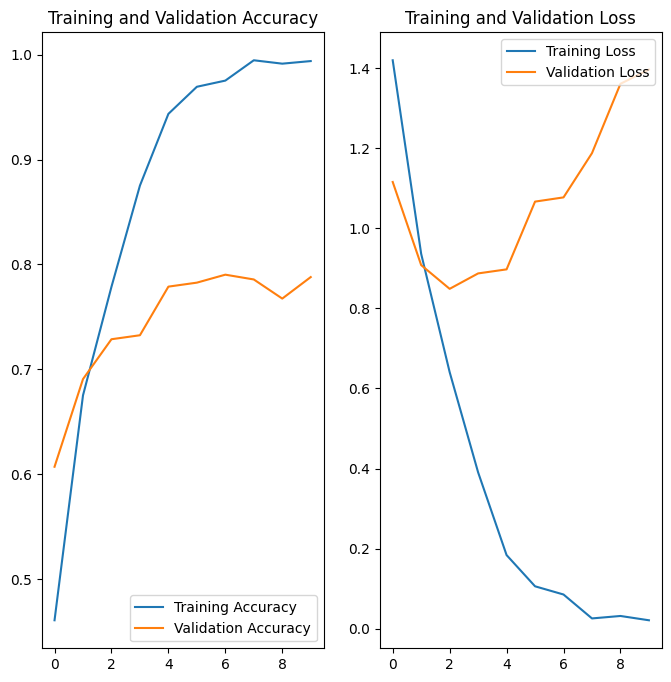

In [ ]:
# train the model
epochs = 10 # количество эпох тренировки
history = model.fit(
	train_ds,
	validation_data=val_ds,
	epochs=epochs)

# visualize training and validation results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Решение проблемы с переобучением
Добавляем аугментацию и регуляризацию (Dropout)

In [ ]:
model = Sequential([
	# т.к. у нас версия TF 2.6 локально
	layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

	# аугментация
	layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
	layers.experimental.preprocessing.RandomRotation(0.1),
	layers.experimental.preprocessing.RandomZoom(0.1),
	layers.experimental.preprocessing.RandomContrast(0.2),

	# дальше везде одинаково
	layers.Conv2D(16, 3, padding='same', activation='relu'),
	layers.MaxPooling2D(),

	layers.Conv2D(32, 3, padding='same', activation='relu'),
	layers.MaxPooling2D(),

	layers.Conv2D(64, 3, padding='same', activation='relu'),
	layers.MaxPooling2D(),

	# регуляризация
	layers.Dropout(0.2),

	layers.Flatten(),
	layers.Dense(128, activation='relu'),
	layers.Dense(num_classes)
])

# compile the model
model.compile(
	optimizer='adam',
	loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
	metrics=['accuracy'])

# print model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 random_flip (RandomFlip)    (None, 180, 180, 3)       0         
                                                                 
 random_rotation (RandomRot  (None, 180, 180, 3)       0         
 ation)                                                          
                                                                 
 random_zoom (RandomZoom)    (None, 180, 180, 3)       0         
                                                                 
 random_contrast (RandomCon  (None, 180, 180, 3)       0         
 trast)                                                          
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)     

# Повторно обучаем нейросеть с новыми слоями и увеличенным количеством эпох обучения

Epoch 1/20
165/165 [==============================] - 203s 1s/step - loss: 1.4386 - accuracy: 0.4583 - val_loss: 1.1818 - val_accuracy: 0.5957
Epoch 2/20
165/165 [==============================] - 199s 1s/step - loss: 1.0984 - accuracy: 0.6066 - val_loss: 1.0136 - val_accuracy: 0.6520
Epoch 3/20
165/165 [==============================] - 199s 1s/step - loss: 0.9799 - accuracy: 0.6498 - val_loss: 0.9887 - val_accuracy: 0.6588
Epoch 4/20
165/165 [==============================] - 201s 1s/step - loss: 0.8888 - accuracy: 0.6864 - val_loss: 0.8559 - val_accuracy: 0.7150
Epoch 5/20
165/165 [==============================] - 199s 1s/step - loss: 0.8292 - accuracy: 0.7094 - val_loss: 0.8918 - val_accuracy: 0.6945
Epoch 6/20
165/165 [==============================] - 208s 1s/step - loss: 0.7889 - accuracy: 0.7200 - val_loss: 0.8751 - val_accuracy: 0.7059
Epoch 7/20
165/165 [==============================] - 199s 1s/step - loss: 0.7411 - accuracy: 0.7409 - val_loss: 0.7971 - val_accuracy: 0.7439

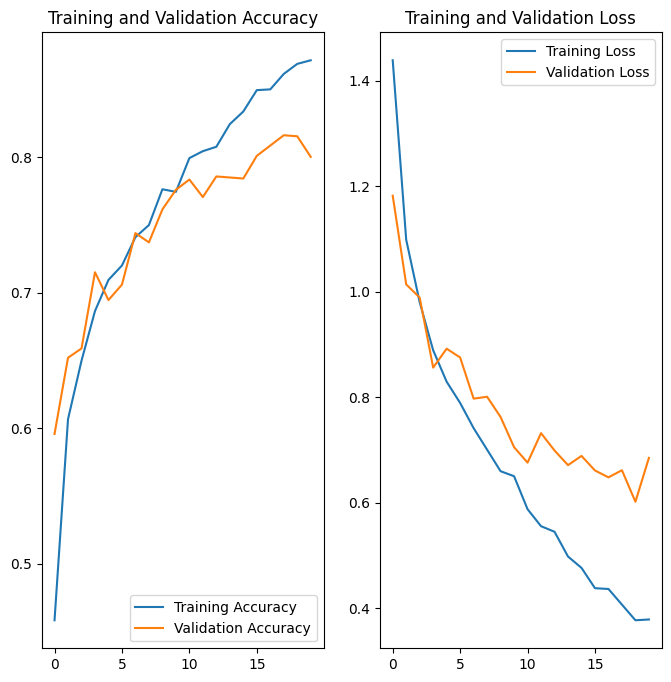

In [ ]:
# train the model
epochs = 20 # количество эпох тренировки
history = model.fit(
	train_ds,
	validation_data=val_ds,
	epochs=epochs)

# visualize training and validation results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Делаем инференс на новом изображении

In [ ]:
drive.mount('/content/drive')
# load image
sport_path = pathlib.Path('/content/drive/MyDrive/Practic/8b3b42e8a8.jpg')

img = tf.keras.utils.load_img(
    sport_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# make predictions
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

# print inference result
print("На изображении {} ({:.2f}% вероятность)".format(
	class_names[np.argmax(score)],
	100 * np.max(score)))

# show the image itself
img.show()

NameError: name 'drive' is not defined